# Movie recommendation engine development: a hybrid approach combinding collaborative filtering and matrix factorization



In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
#from sklearn.model_selection import train_test_split
%matplotlib inline
import os
os.chdir("./Downloads/ml-20m")
from sklearn.neighbors import NearestNeighbors
#from scipy.sparse import csr_matrix
from fuzzywuzzy import fuzz
from itertools import chain

/usr/local/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


1. Load in data

In [2]:
#reading rating data
ratings = pd.read_csv('ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [8]:
ratings.shape

(20000263, 4)

In [3]:
#reading movie data

movies=pd.read_csv('movies.csv')
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
movies.shape

(27278, 3)

In [4]:
n_users = ratings.userId.unique().shape[0]
n_items = ratings.movieId.unique().shape[0]
print('There are {} unique users and {} unique movies in this data set'.format(n_users, n_items))

There are 138493 unique users and 26744 unique movies in this data set


2. Exploration 

In [5]:
movie_ct=pd.DataFrame(ratings.groupby('movieId').size(),columns=['count'])
movie_ct1=movie_ct .sort_values('count', ascending=False).reset_index(drop=True)

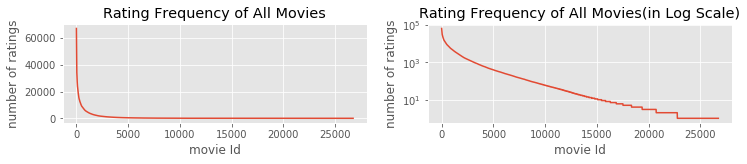

In [9]:
# plot rating frequency of all movies
fig = plt.figure(figsize=(12, 4))
ax1 = fig.add_subplot(221)
ax1.plot(movie_ct1)
ax1.set_xlabel("movie Id")
ax1.set_ylabel("number of ratings")

ax1.set_title('Rating Frequency of All Movies')

ax2 = fig.add_subplot(222)
ax2.plot(movie_ct1)
ax2.set_xlabel("movie Id")
ax2.set_ylabel("number of ratings")
ax2.set_yscale('log')
ax2.set_title('Rating Frequency of All Movies(in Log Scale)')
plt.show()

The distribution for count of ratings on each movie are pretty skewed. 11744 out of 26744 movies received less than 10 ratings. 

In [6]:
movie_ct['count'].quantile(np.arange(1, 0.5, -0.05))


1.00    67310.00
0.95     3612.95
0.90     1305.70
0.85      632.55
0.80      346.00
0.75      205.00
0.70      123.00
0.65       74.00
0.60       47.00
0.55       29.00
Name: count, dtype: float64

About 10% of the movies have 1305 or more ratings. 40% of the movies have 47 or less ratings. I would like to filter out movies which have at least 50 ratings in order to reduce noise and prevent the memory error issue.

In [7]:
# filter data
ratings_thres = 50
active_movies = list(movie_ct.query('count >= @ratings_thres').index)#select movie IDs that have at least 50 ratings
ratings1=ratings[ratings.movieId.isin(active_movies)]
ratings1.shape

(19847947, 4)

3. Build item-based collaborative filtering model using KNN

In [12]:
#created a item-user data matrix, where the rows denote different movies, columns denote different users, and each cell denotes the ratings 
movie_user_mat = ratings1.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# transform matrix to scipy sparse matrix for efficient arithmatic operations
#movie_user_mat_sparse = csr_matrix(movie_user_mat.values)


In [8]:
def recommendation_knn_existing_user(data,userid, n_recommendations,verbose=True):
        rated_high_movies=ratings.loc[ratings.userId==userid,:].sort_values('rating',ascending=False).movieId[:5].tolist()#selected top 5 movies which user has rated high 
        testset=data.loc[[i for i in data.index if i in rated_high_movies],:] #test data 
        trainset=data.loc[[i for i in data.index if i not in rated_high_movies],:] #train data 
        #fit KNN model 
        model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n_recommendations, n_jobs=-1)
        model_knn.fit(trainset)
        distances, indices =model_knn.kneighbors(testset, n_neighbors=n_recommendations)
        #obtain movieIDs for those we recommended  
        raw_recommended=trainset.iloc[list(chain(*indices)),:].index.tolist()
        #merge back movie information 
        recommended=movies.set_index('movieId').loc[raw_recommended]
        #append distance 
        recommended['distance']=list(chain(*distances))
         #obtain movieIDs for those we recommended from
        recommended_from=movies.set_index('movieId').loc[testset.index.tolist()]
        recommended_from=recommended_from.iloc[np.repeat(np.arange(len(recommended_from)), n_recommendations)]
        
        res=pd.concat([recommended_from.reset_index(drop=True), recommended.reset_index(drop=True)], axis=1)
        res.columns=['recommended_from_title',"recommended_from_genres",'title',"genres","distance"]
        #drop duplicated recommended movies and order by similarity 
        res_remove_duplicates=res.sort_values('distance').drop_duplicates('title').sort_index()
        #select top 10 movies with the least distance 
        res_remove_duplicates=res_remove_duplicates.loc[:n_recommendations,:]
        if verbose:
            print('Recommendation system start to make inference')
            print('......\n')
            for i in range(res_remove_duplicates.shape[0]):
                print('{0}: {1}, with distance of {2} from the movie you liked {3}'.format(i+1, res_remove_duplicates.iloc[i,2], res_remove_duplicates.iloc[i,4],res_remove_duplicates.iloc[i,0]))
        return res_remove_duplicates
            
def recommendation_knn_new_user(data,fav_movie, n_recommendations,verbose=True):
        print('You have input movie:', fav_movie)
        match_tuple = []
    # get match
        match_tuple = []
    # get match
        for i in range(movies.shape[0]):
            ratio = fuzz.ratio(movies.title[i].lower(), fav_movie.lower())
            if ratio >= 65:
                match_tuple.append((movies.title[i], movies.movieId[i], ratio))
   # sort
        match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
        if not match_tuple:
            print('Oops! No match is found, input another movie name')
            return
        else:
            print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
        idx=match_tuple[0][1]
        model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n_recommendations, n_jobs=-1)
        model_knn.fit(data)
        distances, indices = distances, indices = model_knn.kneighbors(data.loc[idx:idx+1,:], n_neighbors=n_recommendations+1)

        raw_recommended=data.iloc[list(chain(*indices)),:].index.tolist()[1:]

        recommended=movies.set_index('movieId').loc[raw_recommended]
        #append distance 
        recommended['distance']=list(chain(*distances))[1:]
         #obtain movieIDs for those we recommended from
        recommended_from=movies[movies.movieId==idx]
        recommended_from=recommended_from.iloc[np.repeat(np.arange(len(recommended_from)), 10)]
        res=pd.concat([recommended_from.reset_index(drop=True), recommended.reset_index(drop=True)], axis=1)
        res.columns=['movieId','recommended_from_title',"recommended_from_genres",'title',"genres","distance"]
        #drop duplicated recommended movies and order by similarity 
        res_remove_duplicates=res.sort_values('distance').drop_duplicates('title').sort_index()
        #select top 10 movies with the least distance 
        res_remove_duplicates=res_remove_duplicates.loc[:n_recommendations,:]
        if verbose:
            print('Recommendation system start to make inference')
            print('......\n')
            for i in range(res_remove_duplicates.shape[0]):
                print('{0}: {1}, with distance of {2}'.format(i+1, res_remove_duplicates.iloc[i,3], res_remove_duplicates.iloc[i,5]))

        return res_remove_duplicates

Try out the recommendation system:

suppose we are interested in a specific user on file, we recommended movies based on the top 5 movies he/she has rated: 

In [157]:
#select a random user 
import random
userid=random.randint(1,n_users)
print('User with ID number {} has been selected'.format(userid))

User with ID number 22874 has been selected


In [158]:
recommendation_knn_existing_user(movie_user_mat,userid, n_recommendations=10)

Recommendation system start to make inference
......

1: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981), with distance of 0.39982539188115884 from the movie you liked Princess Bride, The (1987)
2: Star Wars: Episode V - The Empire Strikes Back (1980), with distance of 0.40879310557036697 from the movie you liked Princess Bride, The (1987)
3: Monty Python and the Holy Grail (1975), with distance of 0.4342648863520687 from the movie you liked Princess Bride, The (1987)
4: Back to the Future (1985), with distance of 0.4399884549362366 from the movie you liked Princess Bride, The (1987)
5: Indiana Jones and the Last Crusade (1989), with distance of 0.4505104920892238 from the movie you liked Princess Bride, The (1987)
6: Star Wars: Episode IV - A New Hope (1977), with distance of 0.455221508572182 from the movie you liked Princess Bride, The (1987)
7: Groundhog Day (1993), with distance of 0.4554302067517295 from the movie you liked Princess Bride, The (1987

,recommended_from_title,recommended_from_genres,title,genres,distance
0,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,Raiders of the Lost Ark (Indiana Jones and the...,Action|Adventure,0.399825
1,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,0.408793
2,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy,0.434265
3,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,Back to the Future (1985),Adventure|Comedy|Sci-Fi,0.439988
4,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,Indiana Jones and the Last Crusade (1989),Action|Adventure,0.450510
5,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,0.455222
6,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,Groundhog Day (1993),Comedy|Fantasy|Romance,0.455430
7,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,Ferris Bueller's Day Off (1986),Comedy,0.465793
8,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,0.467011
9,"Princess Bride, The (1987)",Action|Adventure|Comedy|Fantasy|Romance,Ghostbusters (a.k.a. Ghost Busters) (1984),Action|Comedy|Sci-Fi,0.492824


Suppose I just sign up on the website, and the website don't have information about my movie watching history or rating history. Then the system will ask me to name one movie I liked the most, and then recommend movies similar to that.

In [156]:
fav_movie=input('name one of your favourite movie')
recommendation_knn_new_user(data,fav_movie, n_recommendations=10)


name one of your favourite movieiron man
You have input movie: iron man
Found possible matches in our database: ['Iron Man (2008)', 'My Own Man']

Recommendation system start to make inference
......

1: Dark Knight, The (2008), with distance of 0.3742058573335898
2: Star Trek (2009), with distance of 0.4132744620437929
3: WALL·E (2008), with distance of 0.42882540769215305
4: Batman Begins (2005), with distance of 0.4411773473401579
5: Bourne Ultimatum, The (2007), with distance of 0.4508639925222967
6: Casino Royale (2006), with distance of 0.45761216162029694
7: Avatar (2009), with distance of 0.4614256282983722
8: Iron Man 2 (2010), with distance of 0.46337905754915143
9: V for Vendetta (2006), with distance of 0.48080602167268693
10: District 9 (2009), with distance of 0.486612030805717


,movieId,recommended_from_title,recommended_from_genres,title,genres,distance
0,59315,Iron Man (2008),Action|Adventure|Sci-Fi,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,0.374206
1,59315,Iron Man (2008),Action|Adventure|Sci-Fi,Star Trek (2009),Action|Adventure|Sci-Fi|IMAX,0.413274
2,59315,Iron Man (2008),Action|Adventure|Sci-Fi,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi,0.428825
3,59315,Iron Man (2008),Action|Adventure|Sci-Fi,Batman Begins (2005),Action|Crime|IMAX,0.441177
4,59315,Iron Man (2008),Action|Adventure|Sci-Fi,"Bourne Ultimatum, The (2007)",Action|Crime|Thriller,0.450864
5,59315,Iron Man (2008),Action|Adventure|Sci-Fi,Casino Royale (2006),Action|Adventure|Thriller,0.457612
6,59315,Iron Man (2008),Action|Adventure|Sci-Fi,Avatar (2009),Action|Adventure|Sci-Fi|IMAX,0.461426
7,59315,Iron Man (2008),Action|Adventure|Sci-Fi,Iron Man 2 (2010),Action|Adventure|Sci-Fi|Thriller|IMAX,0.463379
8,59315,Iron Man (2008),Action|Adventure|Sci-Fi,V for Vendetta (2006),Action|Sci-Fi|Thriller|IMAX,0.480806
9,59315,Iron Man (2008),Action|Adventure|Sci-Fi,District 9 (2009),Mystery|Sci-Fi|Thriller,0.486612


Until now, we have built a simple recommendation engine using item-based collaborative filtering and KNN algorithm. The model works for general purpose, however, it has several limitation:
    1. It biased towards popular movies: unpopular movies will in general have very low similarity score to all the other movies in the database, despite the fact that they might actually be very similar to some movies in terms of genre, etc. This is usually the downside of item-based collaborative filtering system. 
    2. KNN algorithm is computationally expensive, therefore, it might not be scalale. 
In the next section, we are going to build another recommendation engine using Singular Value Decomposition (SVD), blend the list of recommended movies from this method to the list we obtained from the KNN model, to further improve the recommendation engine.

4. Build movie recommendation engine using SVD 

In [9]:
#created a user-item data matrix, where the rows denote different users, columns denote different movies, and each cell denotes the ratings 
user_movie_mat = ratings1.pivot(index='userId', columns='movieId', values='rating').fillna(0)



In [164]:
user_movie_mat.mean(axis=1)

(138493, 10524)

In [ ]:
#normalize the ratings by user's mean rating 
R_norm=user_movie_mat-user_movie_mat.mean(axis=1)

In [ ]:
#fit SVD 
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_norm) #U: user preference matrix: how each user prefer each concept 
                            #Vt: how relevant each feature is to each movie 
sigma = np.diag(sigma)                    

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            138484, 138485, 138486, 138487, 138488, 138489, 138490, 138491,
            138492, 138493],
           dtype='int64', name='userId', length=138493)

In [ ]:
def recommendation_svd(data,userid,n_recommendations,verbose=True):
    
    R_norm=data-data.mean(axis=1).reshape(-1,1)
    
    U, sigma, Vt = svds(R_norm) 
    sigma = np.diag(sigma)
    all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + data.mean(axis=1)#making predictions
    ind=userid-1
    
    rated_movies=np.where(data[ind]!=0)[0]
    original_ratings=data[ind,rated_movies]
    rated_movies_df = pd.DataFrame(data=np.column_stack((rated_movies+1,original_ratings)),columns=['movieId','rating'])
    rated_movies_df=rated_movies_df.sort_values('rating',ascending=False)
    rated_movies_df=rated_movies_df.merge(movies,'left',on="movieId")
    unratted_movies=np.where(data[ind]==0)[0]
    predicted_ratings=all_user_predicted_ratings[ind,unratted_movies]
    recommended_movies = pd.DataFrame(data=np.column_stack((unratted_movies+1,predicted_ratings)),columns=['movieId','rating'])
    recommended_movies=recommended_movies.merge(movies,'left',on="movieId")
    if verbose:
        print('Recommendation system start to make inference')
        print('......\n')
        for i in range(recommended_movies.shape[0]):
                print('{0}: {1}'.format(i+1, recommended_movies.iloc[i,2]))

    return [rated_movies_df,recommended_movies.sort_values('rating',ascending=False)[:n_recommendations]]

    
    
    
    


5.Combined the two methods 


In [ ]:
def recommendation(new_user=False,movie_user_data,user_movie_data,userid,n_recommendations):
    if not new_user:
        res_knn=recommendation_knn_existing_user(movie_user_data,userid, n_recommendations,verbose=False)
        rated_movie,res_svd=recommendation_svd(user_movie_data,userid,n_recommendations,verbose=False)
        print('Recommendation system start to make inference')
        print('......\n')
        res=[i for i in set(res_knn['title'],res_svd['title'])]
        res_1=res[np.random.randint(0,len(res),size=n_recommendations)]
        for i in range(n_recommendations)):
                print('{0}: {1}'.format(i+1, res_1[i]))
    else:
        fav_movie=input('name one of your favourite movie')
        res_knn=recommendation_knn_new_user(movie_user_data,fav_movie, n_recommendations)
        ind=res_knn.movieId.unique()
        dict1 = dict( (a,0.0) for a in user_movie_data.columns if a!=ind else (a,5.0))
        user_movie_data.append(dict1)
        rated_movie,res_svd=recommendation_svd(user_movie_data,?,n_recommendations,verbose=True)
    
        print('Recommendation system start to make inference')
        print('......\n')
        res=[i for i in set(res_knn['title'],res_svd['title'])]
        res_1=res[np.random.randint(0,len(res),size=n_recommendations)]
        for i in range(n_recommendations)):
                print('{0}: {1}'.format(i+1, res_1[i]))
 

        